# 🐶 End-to-end Multi-Class Dog Breed Classification

This notebook builds an end-to-end multiclass image classifier using Tensorflow 2 and Tensorflow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data comes from Kaggle's Dog Breed Identification competition: [Kaggle](https://www.kaggle.com/c/dog-breed-identification/).

## 3. Evaluation

The evaluation is a file with prediction probabilities forEach dog breed for each test image: [Evaluation](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation).


## 4. Features

Some information about the data:
* images = unstructured data -> it's probably best to use deep learning/transfer learning
* 120 breeds of dogs (multi-class)
* there 10,000+ images in the training set (with labels)
* there are 10,000+ images in the testing set (no labels)



## 0. Get Workspace Ready

* import Tensorflow 2.x
* import Tensorflow Hub
* make sure we're using a GPU


In [9]:
# import Tensorflow TF 2.0
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [10]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

# Check for GPU available
print('GPU', 'available (Yeah!)' if tf.config.list_physical_devices('GPU') else 'not avaiable...')

TF version: 2.1.0
TF Hub version: 0.7.0
GPU available (Yeah!)


### Getting Data Ready

Transform input data into numerical format (Tensors).

Let's start by accessing our data and checking out labels

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

labels_csv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/dog-breed/labels.csv')
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,c6490dd60b2c31345e74f93b1c4231e5,scottish_deerhound
freq,1,126


In [12]:
# How images are there for each breed?
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

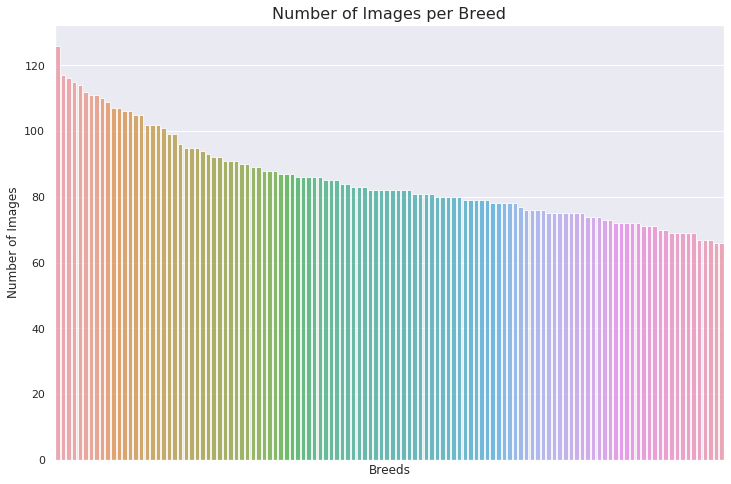

In [13]:
# Plotting a bar chart for the target values
breed_count = labels_csv['breed'].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(breed_count.index, breed_count.values,
            order=breed_count.index,
            alpha=0.8)
plt.title('Number of Images per Breed', fontdict={'fontsize': 16})
plt.ylabel('Number of Images')
plt.xlabel('Breeds')
plt.xticks([]);

In [14]:
# Average number of images per breed
breed_count.median()

82.0

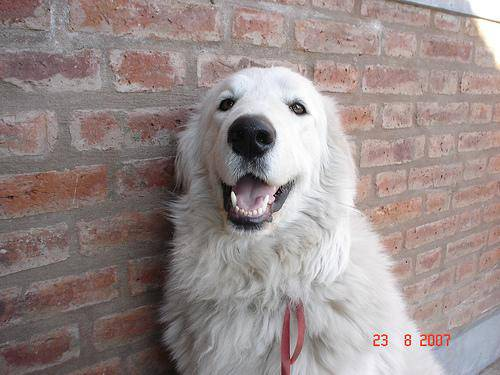

In [15]:
# Let's view an image
from IPython.display import Image
Image('/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/0a0c223352985ec154fd604d7ddceabd.jpg')

### Getting images and their labels

Let's get a list of all image file pathnames.

In [16]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [17]:
# Create pathnames from image IDs
fpath = '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/'
filenames = [fpath + fname + '.jpg' for fname in labels_csv['id']]
filenames[:5]

['/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Colab Notebooks/data/dog-breed/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [19]:
# Check if number of filenames matches number of actual image files
import os
if len(os.listdir(fpath)) == len(filenames):
  print('Filenames match actual amount of files. Proceed.')
else:
  print(f'Error: actual num of files: {len(os.listdir(fpath))} - labels.csv: {len(filenames)}')

Filenames match actual amount of files. Proceed.


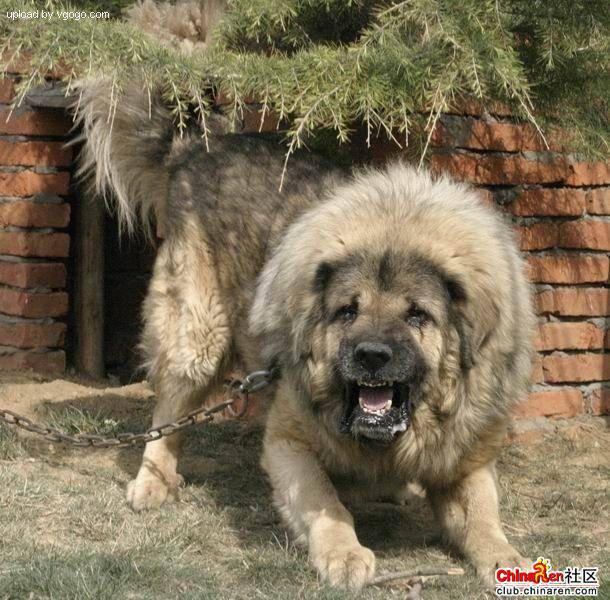

In [21]:
# Another check
Image(filenames[9000])